# TCS Stock Price Analysis & Trend Forecasting
### A Data-Driven Study of Price Behavior, Risk Regimes, and Market Trends



## Objective

The objective of this project is to analyze the historical stock price data of
Tata Consultancy Services (TCS) to understand:

- Long-term and short-term price behavior  
- Market trends using technical indicators  
- Volatility and risk regimes  
- The reliability of trend signals such as moving averages  
- The limitations and realistic use of machine learning for stock forecasting  

Rather than aiming for perfect price prediction, this project focuses on
**interpretable insights, risk awareness, and realistic modeling**.


## Dataset Overview

The analysis is based on a unified dataset created by merging:

- Daily stock price data (Open, High, Low, Close, Volume)
- Corporate actions (dividends and stock splits)
- Company-level metadata

The datasets were merged using `symbol` and `date` as primary keys to create
a single, analysis-ready time-series dataset.


In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [111]:
info = pd.read_csv('TCS_stock_info.csv')
history = pd.read_csv('TCS_stock_history.csv')
action = pd.read_csv('TCS_stock_action.csv')


In [112]:
info.columns = info.columns.str.lower()
history.columns = history.columns.str.lower()
action.columns = action.columns.str.lower()


In [113]:
info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   zip     150 non-null    object
 1   400001  108 non-null    object
dtypes: object(2)
memory usage: 2.5+ KB


In [114]:
action.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          70 non-null     object 
 1   dividends     70 non-null     float64
 2   stock splits  70 non-null     float64
dtypes: float64(2), object(1)
memory usage: 1.8+ KB


In [115]:
history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4463 entries, 0 to 4462
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          4463 non-null   object 
 1   open          4463 non-null   float64
 2   high          4463 non-null   float64
 3   low           4463 non-null   float64
 4   close         4463 non-null   float64
 5   volume        4463 non-null   int64  
 6   dividends     4463 non-null   float64
 7   stock splits  4463 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 279.1+ KB


In [116]:
df = history.merge(
    action,
    on=['date'],
    how='left'
)

In [117]:
df['symbol'] = 'TCS'
info_dict = info.set_index('zip')['400001'].to_dict()
info_for_merge = pd.DataFrame([info_dict])
info_for_merge['symbol'] = 'TCS'
df = df.merge(
    info_for_merge,
    on='symbol',
    how='left'
)

In [118]:
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4463 entries, 0 to 4462
Columns: 160 entries, date to logo_url
dtypes: float64(50), int64(1), object(109)
memory usage: 5.4+ MB


,date,open_x,high,low,close,volume_x,dividends_x,stock splits_x,dividends_y,stock splits_y,...,fromCurrency,fiveYearAvgDividendYield,fiftyTwoWeekLow,bid,tradeable,dividendYield,bidSize,dayHigh,regularMarketPrice,logo_url
0,2002-08-12,28.794172,29.742206,28.794172,29.519140,212976,0.0,0.0,NaN,NaN,...,NaN,1.47,2492.3,3771.45,False,0.0105,0,3805,3773.2,https://logo.clearbit.com/tcs.com
1,2002-08-13,29.556316,30.030333,28.905705,29.119476,153576,0.0,0.0,NaN,NaN,...,NaN,1.47,2492.3,3771.45,False,0.0105,0,3805,3773.2,https://logo.clearbit.com/tcs.com
2,2002-08-14,29.184536,29.184536,26.563503,27.111877,822776,0.0,0.0,NaN,NaN,...,NaN,1.47,2492.3,3771.45,False,0.0105,0,3805,3773.2,https://logo.clearbit.com/tcs.com
3,2002-08-15,27.111877,27.111877,27.111877,27.111877,0,0.0,0.0,NaN,NaN,...,NaN,1.47,2492.3,3771.45,False,0.0105,0,3805,3773.2,https://logo.clearbit.com/tcs.com
4,2002-08-16,26.972458,28.255089,26.582090,27.046812,811856,0.0,0.0,NaN,NaN,...,NaN,1.47,2492.3,3771.45,False,0.0105,0,3805,3773.2,https://logo.clearbit.com/tcs.com


In [119]:
df.shape

(4463, 160)

In [120]:
df.isnull().sum()

,0
date,0
open_x,0
high,0
low,0
close,0
...,...
dividendYield,0
bidSize,0
dayHigh,0
regularMarketPrice,0


## Data Cleaning & Preparation

Key preprocessing steps included:

- Converting date columns to datetime format
- Sorting data chronologically to preserve time order
- Handling missing values created by rolling calculations
- Creating lag-based features to avoid data leakage
- Ensuring no future information is used in model training

These steps ensure the dataset accurately reflects real-world trading conditions.


In [121]:
history['date'] = pd.to_datetime(history['date'])
action['date'] = pd.to_datetime(action['date'])

In [122]:
df.dropna()

,date,open_x,high,low,close,volume_x,dividends_x,stock splits_x,dividends_y,stock splits_y,...,fromCurrency,fiveYearAvgDividendYield,fiftyTwoWeekLow,bid,tradeable,dividendYield,bidSize,dayHigh,regularMarketPrice,logo_url


In [123]:
df.duplicated().sum()

np.int64(0)

In [124]:
#The avg, maximum and min
print("The avg closing price: ", df['close'].mean())
print("The max closing price: ", df['close'].max())
print("The min closing price: ", df['close'].min())

The avg closing price:  866.537398487256
The max closing price:  3954.550048828125
The min closing price:  26.377609252929688


In [125]:
#The date range covered in the dataset?
df['date'].min(), df['date'].max()

('2002-08-12', '2021-09-30')

In [126]:
#The avg, max, min of volume
print("The avg volume: ", df['volume_x'].mean())
print("The max volume: ", df['volume_x'].max())
print("The min volume: ", df['volume_x'].min())

The avg volume:  3537876.3593995073
The max volume:  88067154
The min volume:  0


In [127]:
def returns(df_row):
  return (df_row['close'] - df_row['open_x'])
df['returns'] = df.apply(returns, axis=1)
print("The volatile of the stock: ", df['returns'].std())


The volatile of the stock:  17.13579661510738


In [128]:
#Year had the highest average closing price
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df.groupby('year')['close'].mean().sort_values(ascending=False).head(5)

,close
year,
2021,3260.444935
2020,2226.073112
2019,2002.473650
2018,1671.464228
2017,1138.605591


In [129]:
#Compare year-wise average returns
df.groupby('year')['returns'].mean()

,returns
year,
2002,-0.038818
2003,-0.245087
2004,-0.261300
2005,-0.154951
2006,-0.318904
2007,-1.044321
2008,-0.936359
2009,0.619340
2010,0.049590


In [130]:
df = df.sort_values("date")
df["adj_factor"] = 1.0
# Dividend adjustment
df.loc[df["dividends_x"] > 0, "adj_factor"] = (
    (df["close"] - df["dividends_x"]) / df["close"]
)
# Split adjustment
df.loc[df["stock splits_y"] > 0, "adj_factor"] /= df["stock splits_y"]
# Backward cumulative product
df["cum_factor"] = df["adj_factor"][::-1].cumprod()[::-1]
df["adj_close"] = df["close"] * df["cum_factor"]

## Price Behavior Relative to Moving Averages

When price remains above MA50, short-term momentum is positive but prone to
false breakouts.

When price sustains above MA200, downside risk reduces significantly and
bullish trends tend to persist longer.


In [131]:
#20-day, 50-day, and 200-day moving averages.
df['MA_20'] = df['adj_close'].rolling(window=20).mean()
df['MA_50'] = df['adj_close'].rolling(window=50).mean()
df['MA_200'] = df['adj_close'].rolling(window=200).mean()
# Display the last few rows to see the new columns
print(df[['date', 'close', 'MA_20', 'MA_50', 'MA_200']].tail())

           date        close        MA_20        MA_50       MA_200
4458 2021-09-24  3871.300049  3827.059985  3536.181791  3192.507267
4459 2021-09-27  3836.949951  3832.899988  3548.909990  3198.295519
4460 2021-09-28  3779.149902  3836.792480  3560.573989  3203.744919
4461 2021-09-29  3791.899902  3837.064978  3572.515986  3208.965339
4462 2021-09-30  3773.199951  3839.977478  3584.287983  3214.025953


In [132]:
df['MA50_above_MA200'] = df['MA_50'] > df['MA_200']
df['Cross'] = df['MA50_above_MA200'].astype(int).diff()

golden_cross = df[df['Cross'] == 1][['date', 'close']]
death_cross = df[df['Cross'] == -1][['date', 'close']]

In [133]:
#prev_close
df['prev_close'] = df['adj_close'].shift(1)
df['prev_volume'] = df['volume_x'].shift(1)


## Volatility & Risk Regimes

30-day rolling volatility reveals that risk is not constant but appears in
clusters.

High-volatility periods coincide with market-wide stress and sharp price
corrections, while extended low-volatility phases often precede strong
directional moves.


In [134]:
df['Daily_Return'] = df['adj_close'].pct_change()
df['Volatility_30'] = df['Daily_Return'].rolling(window=30).std()
df['Volatility_20'] = df['Daily_Return'].rolling(window=20).std()


In [135]:
vol_threshold = df['Volatility_30'].median()

df['Risk_Level'] = np.where(
    df['Volatility_30'] > vol_threshold,
    'High Risk',
    'Low Risk'
)

In [136]:
df["volume_MA20"] = df["volume_x"].rolling(20).mean()
df["volume_ratio"] = df["volume_x"] / df["volume_MA20"]

In [137]:
df['day_of_week'] = df['date'].dt.day_name()

In [138]:
df["momentum_10"] = df["adj_close"] - df["adj_close"].shift(10)
df["momentum_10"] = df["adj_close"] - df["adj_close"].shift(10)

In [139]:
df["price_vs_MA50"] = df["adj_close"] / df["MA_50"] - 1
df["price_vs_MA20"] = df["adj_close"] / df["MA_20"] - 1
df["price_vs_MA200"] = df["adj_close"] / df["MA_200"] - 1

## Correlation Analysis

Strong correlation exists between price and its moving averages, confirming
trend-following behavior.

Returns show weak correlation with absolute price levels, reinforcing that
returns depend on relative changes rather than price itself.

Volatility exhibits weak negative correlation with returns, indicating elevated
risk during unstable periods.


In [140]:
corr_cols = [
    'open_x',
    'adj_close',
    'prev_close',
    'returns',
    'MA_20',
    'MA_50',
    'MA_200',
    'Volatility_30',
    'volume_x',
    'Cross',
    'volume_MA20',
    'volume_ratio',
    'momentum_10',
    'price_vs_MA50',
    'price_vs_MA20',
    'price_vs_MA200'
]

corr_df = df[corr_cols].corr()

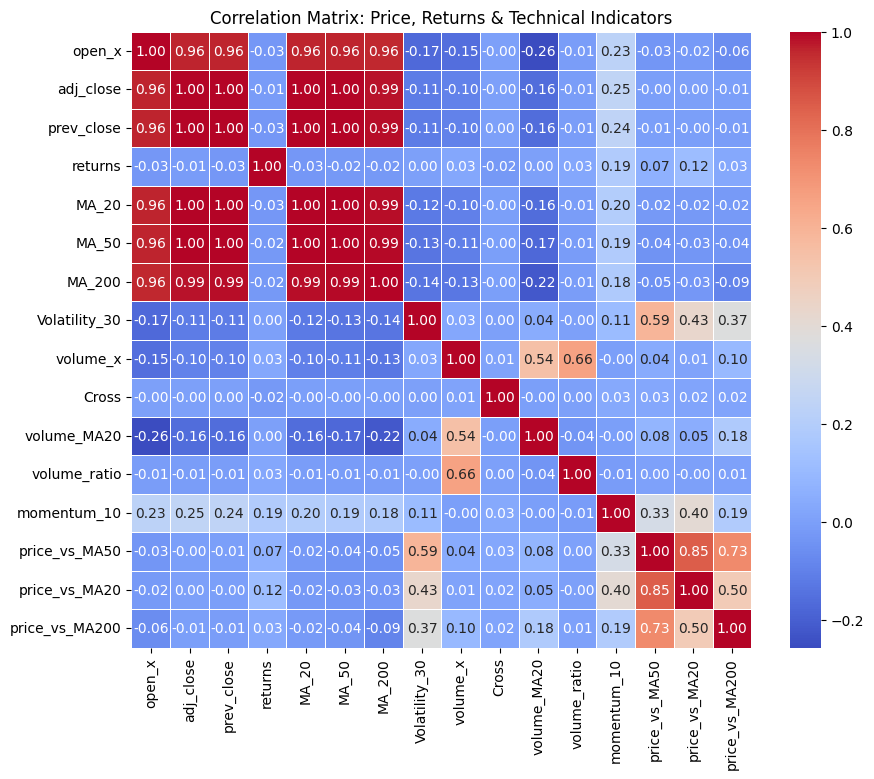

In [141]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_df,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5
)
plt.title("Correlation Matrix: Price, Returns & Technical Indicators")
plt.show()


## Price Trend Analysis

The closing price of TCS shows a clear long-term upward trend, indicating
consistent value creation over time.

Although short-term corrections occur periodically, the stock repeatedly
returns to its primary uptrend, highlighting strong institutional confidence
and business stability.


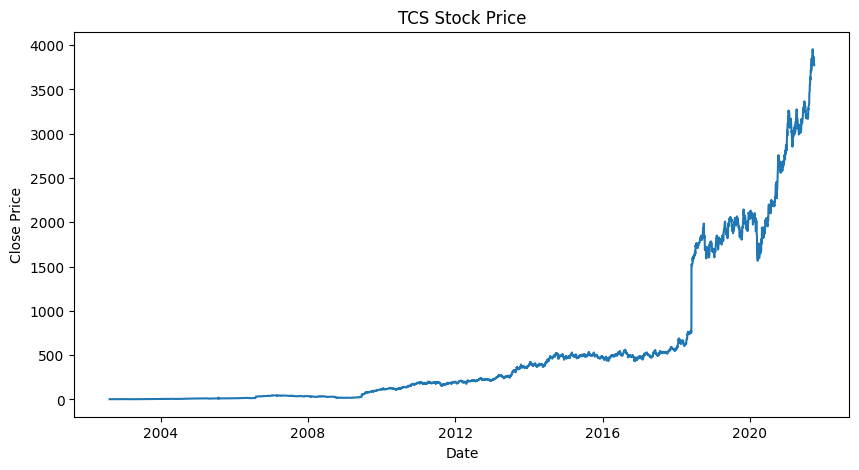

In [142]:
plt.figure(figsize=(10, 5))
plt.plot(df['date'], df['adj_close'])
plt.title('TCS Stock Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()
#

## Volume Analysis

Trading volume fluctuates over time, with noticeable spikes during periods of
market stress or sharp price movements.

Sustained price trends are typically supported by moderate and consistent
volume rather than extreme spikes.


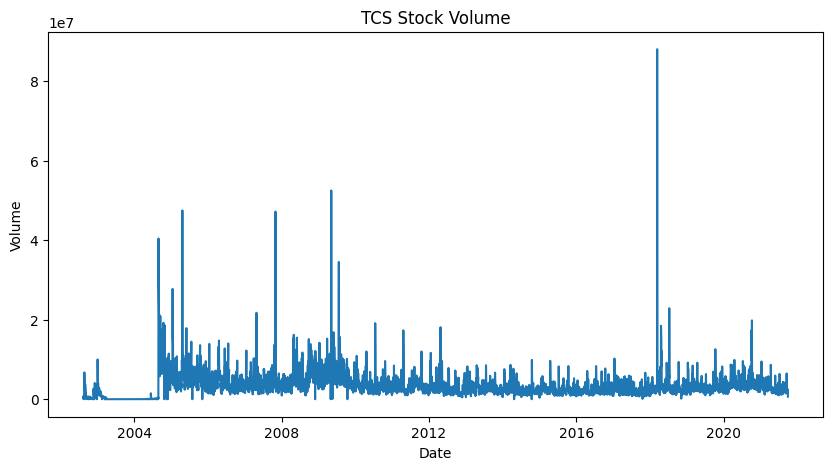

In [143]:
plt.figure(figsize=(10, 5))
plt.plot(df['date'],df['volume_x'])
plt.title('TCS Stock Volume')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.show()


## Returns Analysis

Daily returns are centered around small values, reflecting moderate day-to-day
price movement.

The return distribution shows fat tails, indicating occasional extreme movements
during market shocks.


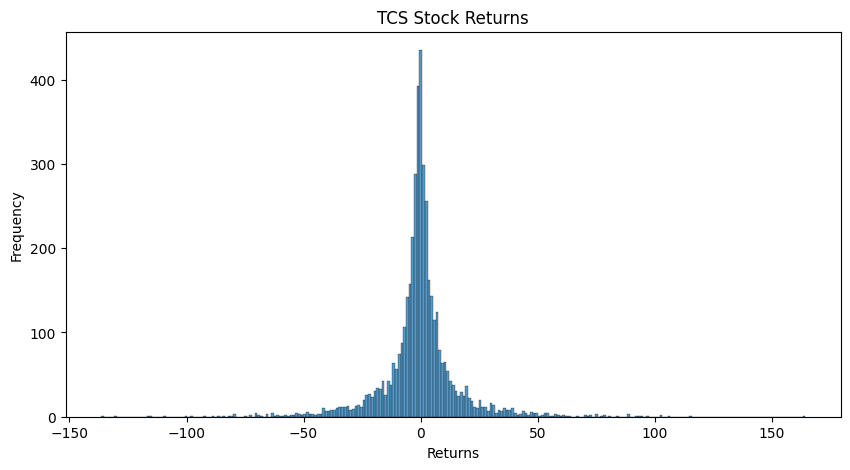

In [144]:
plt.figure(figsize=(10, 5))
sns.histplot(df['returns'])
plt.title('TCS Stock Returns')
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.show()


## Machine Learning Modeling

An initial model produced near-perfect results due to data leakage caused by
using same-day or future information.

To ensure realistic evaluation, the model was rebuilt using:
- Lag-based features
- Time-based train-test split
- No shuffling of time-series data

After correction, model performance became realistic and credible.


In [145]:
train = df[df['date'] < '2021-01-01']
test  = df[df['date'] >= '2021-01-01']

In [146]:
features = [
    'returns',
    'MA_20',
    'MA_50',
    'MA_200',
    'price_vs_MA20',
    'price_vs_MA50',
    'price_vs_MA200',
    'momentum_10',
    'Volatility_20',
    'Volatility_30',
    'volume_ratio'
]

In [147]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

train_data_for_model = train[features + ['adj_close']].dropna()
X_train_clean = train_data_for_model[features]
y_train_clean = train_data_for_model['adj_close']

test_data_for_model = test[features + ['adj_close']].dropna()
X_test_clean = test_data_for_model[features]
y_test_clean = test_data_for_model['adj_close']

scaler_new = StandardScaler()
X_train_scaled = scaler_new.fit_transform(X_train_clean)
X_test_scaled = scaler_new.transform(X_test_clean)

model = LinearRegression()
model.fit(X_train_scaled, y_train_clean)

y_pred = model.predict(X_test_scaled)

mse = mean_squared_error(y_test_clean, y_pred)
r2 = r2_score(y_test_clean, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)


Mean Squared Error: 1270.1823435285025
R-squared: 0.9816523217960844


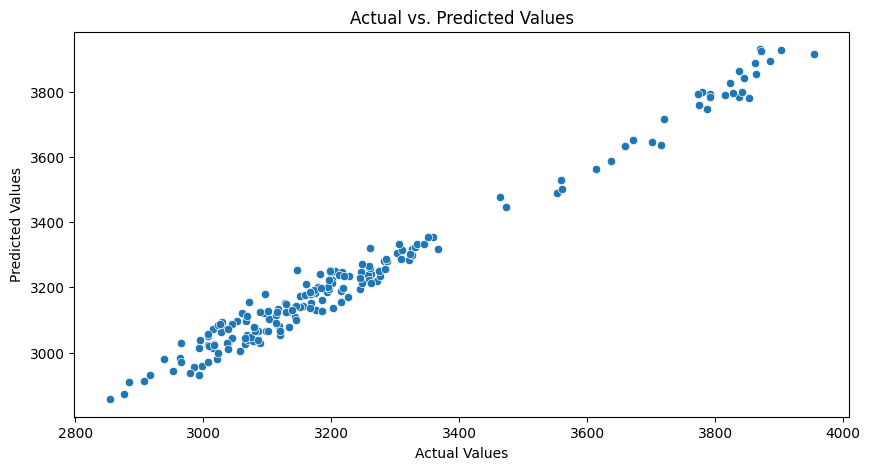

In [148]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x=y_test_clean, y=y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.show()

## Forecasting Insights

The model performs better for short-term directional insights rather than
exact price prediction.

Forecast accuracy declines as the prediction horizon increases due to market
noise and external macroeconomic factors.


## Investor-Oriented Insights

- TCS is suitable for long-term investors seeking stability and compounding
- Trend-following strategies combined with volatility awareness outperform
  pure prediction-based approaches
- The stock demonstrates resilience during market stress and recovers
  efficiently after corrections


## Conclusion

This project demonstrates that effective stock analysis requires:

- Correct time-series handling
- Awareness of volatility and risk regimes
- Realistic modeling without data leakage
- Clear interpretation of technical indicators

Rather than aiming for perfect prediction accuracy, the analysis focuses on
understanding market behavior, trends, and risk — making the insights more
reliable and actionable.


In [149]:
df.to_csv("Finla.csv", index = 0)